<a href="https://colab.research.google.com/github/rafaelsguerra/data_science_portfolio/blob/main/Utilizando_classifica%C3%A7%C3%A3o_para_prever_contratos_de_seguros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando classificação para prever contratos de seguros

Neste artigo, iremos explorar um conjunto de dados de uma seguradora que provê seguro saúde para seus clientes e aplicar técnicas de aprendizagem de máquina para prever se os mesmos estariam interessados em adquirir um seguro para seus veículos.

Construir um modelo desse tipo pode se tornar muito útil para a empresa, pois ajudará a planejar a sua estratégia de comunicação e otimizará seu plano de negócios e receita.

## Explorando os dados

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(42)

data = pd.read_csv('train.csv')

Esta é uma breve descrição das colunas presentes nos dados:
- **id**: ID única do cliente;
- **Age**: idade do cliente;
- **Driving_License**: variável binária que indica se o cliente possui habilitação;
- **Region_code**: código para a região do cliente;
- **Previusly_Insured**: variável binária que indica se o cliente já usufruiram do seguro para veiculos no passado;
- **Vehicle_Age**: idade do veículo;
- **Vehicle_Damage**: variável binária que indica se o veículo sofreu danos no passado;
- **Annual_Premium**: taxa paga anualmente;
- **Policy_Sales_Channel**: código anonimizado para indicar o canal de contato com o cliente (correspondênica, telefone, pessoalmente, etc.);
- **Vintage**: tempo em dias em que o cliente é segurado pela empresa;
- **Response**: variável binária que indica se o cliente está interessado em adquirir um seguro para seu veículo. É a variável alvo.

In [ ]:
data.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Distribuição das variáveis



In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


Vamos tirar alguns insights desta tabela:
- Um cliente possui idade média de aproximadamente 39 anos;
- Praticamente todos os clientes (mais de 99%) possuem habilitação;
- Aproximadamente metade dos clientes já utilizou seguro no passado;
- Todos os clientes são segurados por menos de um ano. Possivelmente, a seguradora esteja aberta a pouco tempo

É possível observar que nem todas as variáveis estão presentes nesta tabela. Isso acontece por que existem variáves categóricas no conjunto de dados e a função ```describe()```, por padrão, as retira quando também existem variáveis numéricas. Deixemos de lado as numéricas e olhemos as categóricas a seguir.

In [ ]:
data.describe(exclude=[np.number]).T

,count,unique,top,freq
Gender,381109,2,Male,206089
Vehicle_Age,381109,3,1-2 Year,200316
Vehicle_Damage,381109,2,Yes,192413


Aqui podemos observar que:
- Um pouco mais da metade dos clientes são do sexo masculino;
- Um pouco mais da metade dos veículos dos clientes tem entre 1 e dois anos de uso;
- Praticamente metade dos veículos já sofreu avarias no passado.

### Distribuição das classes

Como queremos prever se o cliente deseja o seguro para seu veículo, vamos observar graficamente como esta variável está distribuída no conjunto de dados.

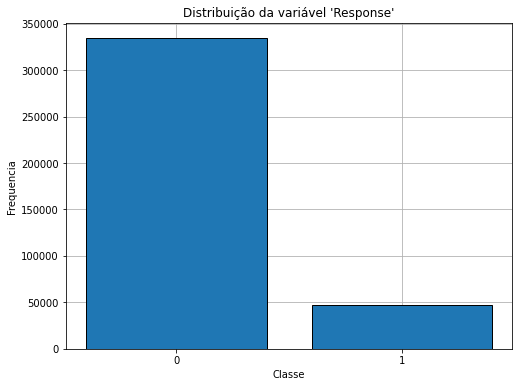

In [ ]:
from matplotlib import pyplot as plt

classes = data['Response'].apply(str).value_counts()
plt.figure(figsize=(8,6))

x = classes.index

plt.bar(x, classes, zorder=3, edgecolor='black')
plt.title('Distribuição da variável \'Response\'')
plt.xlabel('Classe')
plt.ylabel('Frequencia')
plt.grid()
plt.show()

É possível identificar claramente que há um desbalanceamento entre as classes. Enquanto que quase 350 mil entradas indicam que o cliente não está interessado no seguro para veículos, apenas quase 50 mil mostram o contrário, ou seja, um pouco mais que 12% dos clientes. Se utilizarmos estes dados do jeito que estão no treino, o modelo irá assimilar um viés acarretando em classificações errôneas. Neste caso, se faz necessário uma reamostragem.

Existem várias estratégias de reamostragem. A que será aplicada neste artigo é chamada de **undersampling** onde é reduzida aleatoriamente a quantidade de amostras de uma classe a fim de tornar a distribuição das classes mais equilibrada. Iremos adotar uma proporção **50/50**, mas outras ao redor de **60/40** também são aceitáveis.

In [ ]:
n_samples = int(len(data[data['Response'] == 1]))
balanced_data = pd.concat([data[data['Response'] == 1],
                        data[data['Response'] == 0].sample(n_samples)],
                        ignore_index=True).reset_index(drop=True)

Agora verificando o gráfico abaixo, vemos que as classes estão equilibradas.

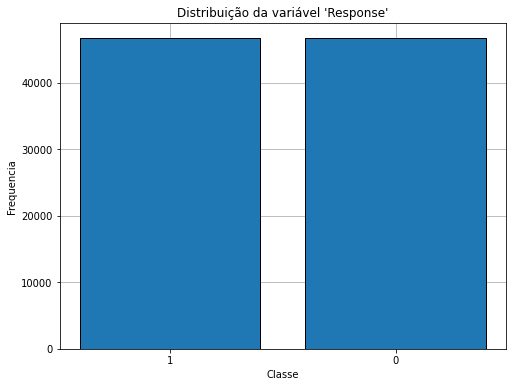

In [ ]:
classes = balanced_data['Response'].apply(str).value_counts()
plt.figure(figsize=(8,6))

plt.bar(classes.index, classes, zorder=3, edgecolor='black')
plt.title('Distribuição da variável \'Response\'')
plt.xlabel('Classe')
plt.ylabel('Frequencia')
plt.grid()
plt.show()

### Correlação entre variáveis

Observe o gráfico abaixo:

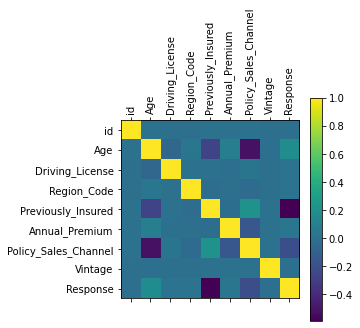

In [ ]:
numerical_variables = balanced_data.select_dtypes([np.number])
plt.matshow(numerical_variables.corr())
plt.xticks(range(numerical_variables.shape[1]), numerical_variables.columns, rotation=90)
plt.yticks(range(numerical_variables.shape[1]), numerical_variables.columns)
plt.colorbar()
plt.show()

Utilizando a correlação de Pearson (padrão utilizado na função ```corr()```), podemos observar que os pares de variáveis com correlação mais fortes são: 
- 'Policy_Sales_Channel' e 'Age'
- 'Response' e Previously_Injured

Estes pares apresentam uma correlação de aproximadamente -0.5, convencionalmente classificada como média, portanto não será necessário remover estas variáveis. É necessário notar que as variáveis categóricas não foram incluídas, pois não é possível determinar a correlação com variáveis deste tipo.

## Pré-processamento

Nesta fase iremos começar a preparar os dados para que sejam utilizados em modelos. 

### Variáveis irrelevantes

Em alguns conjuntos dados existem variáveis que são facilmente identicáveis como irrelevantes, pois não trazem informação. É o caso de variáveis que informam algum tipo de indexação, como ID's, cpf, etc. Neste conjunto, existe a variável 'id' que se encaixa nesta descrição, portanto será retirada.


In [ ]:
balanced_data.drop('id', axis=1, inplace=True)

### Encoding

Como existem variáveis categóricas nos dados, elas não poderão ser introduzidas nos modelos, portanto é preciso transformá-las em numéricas. Neste artigo, iremos aplicar as técnicas de **label encoding** e **one-hot-encoding**.

Como a variável 'Vehicle_Age' é categórica e parece ser relevante para o modelo, passarão pelo processo de one-hot-encoding. As variáveis 'Gender' e 'Region_Code' por serem binárias, possuem apenas duas classes, logo, elas passarão pelo processo de label encoding.

In [ ]:
encoded = pd.get_dummies(balanced_data['Vehicle_Age'])
balanced_data = balanced_data.merge(encoded, left_index=True, right_index=True)
balanced_data.drop('Vehicle_Age', axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

gender = le.fit_transform(balanced_data['Gender'])
vehicle_damage = le.fit_transform(balanced_data['Vehicle_Damage'])

balanced_data['Gender'] = gender
balanced_data['Vehicle_Damage'] = vehicle_damage

In [ ]:
balanced_data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,1-2 Year,< 1 Year,> 2 Years
0,1,44,1,28.0,0,1,40454.0,26.0,217,1,0,0,1
1,1,47,1,28.0,0,1,38294.0,26.0,27,1,0,0,1
2,0,56,1,28.0,0,1,32031.0,26.0,72,1,1,0,0
3,0,47,1,35.0,0,1,47576.0,124.0,46,1,1,0,0
4,1,37,1,6.0,0,1,2630.0,156.0,147,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93415,1,50,1,28.0,0,1,36683.0,26.0,282,0,0,0,1
93416,1,43,1,8.0,0,0,34328.0,26.0,206,0,1,0,0
93417,1,41,1,8.0,1,0,59821.0,26.0,69,0,1,0,0
93418,1,34,1,37.0,1,0,40522.0,152.0,53,0,0,1,0


Há uma observação nas variáveis 'Policy_Sales_Channel' e 'Region_Code'. Apesar delas serem numéricas, cada único valor presente nessas variáveis representam um meio de comunicação com um cliente e sua localidade, respectivamente. Isso irá ocasionar num grande aumento no numero de variáveis no dados. Há diversas estratégias para contornar isso, como selecionar os top-n valores mais frequentes. Neste artigo, iremos apenas adicionar todas as variávies. Portanto, 'Policy_Sales_Channel' e 'Region_Code' também irão passar por um processo de one-hot-encoding.

In [ ]:
policy_sales_channel_encoded = pd.get_dummies(balanced_data['Policy_Sales_Channel'], prefix='Channel')
region_code_encoded = pd.get_dummies(balanced_data['Region_Code'], prefix='Region_Code')

balanced_data = balanced_data.merge(policy_sales_channel_encoded, left_index=True, right_index=True)
balanced_data = balanced_data.merge(region_code_encoded, left_index=True, right_index=True)

balanced_data = balanced_data.drop(['Policy_Sales_Channel', 'Region_Code'], axis=1)

### Feature scaling

Como visto na seção de exploração dos dados, algumas variáveis numéricas possuem uma grande amplitude. Isso pode afetar a peformance de vários modelos, principalmente os que utilizam gradiente descendente, pois os coeficientes irão convergir mais rapidamente em direção ao ponto mínimo da função de custo. Modelos baseados em árvores não levam a distância em consideração, por isso não é necessário realizar o procedimento. Como iremos avaliar mais de um modelo, iremos escalar os dados.

Há várias maneiras de escalar os dados, sendo as mais populares, a **padronização**, na qual os valores serão recalculados de modo que a média seja 1 e o desvio padrão seja 0, e a **normalização**, onde os valores deverão estar dentro de um alcance fixo, mais comumente, entre 1 e 0. Esta última será aplicada neste artigo. Deve-se notar que a variável alvo 'Response' não é normalizada.

In [ ]:
balanced_data.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,1-2 Year,< 1 Year,> 2 Years,Channel_1.0,Channel_2.0,Channel_3.0,Channel_4.0,Channel_7.0,Channel_8.0,Channel_9.0,Channel_10.0,Channel_11.0,Channel_12.0,Channel_13.0,Channel_14.0,Channel_15.0,Channel_16.0,Channel_17.0,Channel_18.0,Channel_19.0,Channel_20.0,Channel_21.0,Channel_22.0,Channel_23.0,Channel_24.0,Channel_25.0,Channel_26.0,Channel_27.0,Channel_28.0,Channel_29.0,Channel_30.0,Channel_31.0,...,Region_Code_13.0,Region_Code_14.0,Region_Code_15.0,Region_Code_16.0,Region_Code_17.0,Region_Code_18.0,Region_Code_19.0,Region_Code_20.0,Region_Code_21.0,Region_Code_22.0,Region_Code_23.0,Region_Code_24.0,Region_Code_25.0,Region_Code_26.0,Region_Code_27.0,Region_Code_28.0,Region_Code_29.0,Region_Code_30.0,Region_Code_31.0,Region_Code_32.0,Region_Code_33.0,Region_Code_34.0,Region_Code_35.0,Region_Code_36.0,Region_Code_37.0,Region_Code_38.0,Region_Code_39.0,Region_Code_40.0,Region_Code_41.0,Region_Code_42.0,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,1,44,1,0,1,40454.0,217,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,47,1,0,1,38294.0,27,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,56,1,0,1,32031.0,72,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,47,1,0,1,47576.0,46,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,37,1,0,1,2630.0,147,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

normalized = scaler.fit_transform(balanced_data.drop('Response', axis=1))
normalized = pd.DataFrame(normalized)

Por fim, esta é a cara do conjunto de dados que será usado para treinar os modelos:

In [ ]:
normalized.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,1.0,0.369231,1.0,0.0,1.0,0.070366,0.716263,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.415385,1.0,0.0,1.0,0.066347,0.058824,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.553846,1.0,0.0,1.0,0.054696,0.214533,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.415385,1.0,0.0,1.0,0.083615,0.124567,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.261538,1.0,0.0,1.0,0.000000,0.474048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


É valido salientar que este conjunto de dados não apresenta valores nulos, portanto não será necessário realizar imputação nos dados.

## Modelagem

Nesta seção, iremos pegar os dados já tratados e aplicá-los em alguns modelos de aprendizagem de máquina. Primeiramente, vamos dividir o conjunto em treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(normalized, balanced_data['Response'], test_size=0.2)

### Validação cruzada

Neste artigo iremos aplicar validação cruzada nos modelos. Esta técnica é bastante utilizada e consiste em separar todo o conjunto de dados em várias partições e utilizar algumas delas para estimar os parâmetros dos modelos, enquanto as outras serão usadas na validação.

Há várias maneiras de realizar o particionamento dos dados, sendo as mais populares **hold-out**, **leave-one-out** e **k-fold** que será utilizada neste artigo.

A validação k-fold simplesmente divide o conjunto em k partições, utiliza uma delas para teste e as outras k-1 serão utilizadas para treino. Este processo se repete k vezes, de modo que cada partição seja utilizada para teste uma vez.

Por hora, vamos realizar os preparativos para que a validação seja feita em cada modelo.

In [ ]:
from sklearn.model_selection import StratifiedKFold

folds = 10
k_fold = StratifiedKFold(folds)

A função a seguir irá ajudar a obter as métricas que queremos avaliar em cada modelo.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

def get_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(f'Acurácia: {accuracy}')
  print(f'Precisão: {precision}')
  print(f'Recall: {recall}')
  print(f'F1: {f1}')

### Regressão Logística

A regressão logística é um modelo de classificação que utiliza uma função sigmoide para determinar as probabilidades de uma entrada do conjunto de dados pertencer a uma determinada classe. O modelo da biblioteca **scikit-learn** utiliza regularização L2 por padrão. Aproveitando-se disso, vamos usar diferentes valores para dosar a força de regularização. Na regressão logística, quanto menor o valor, maior a força.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_c = logreg_C[0]
best_score, best_accuracy, best_precision, best_recall = 0, 0, 0, 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    recall = 0
    precision = 0
    for train_index, test_index in k_fold.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model = LogisticRegression(C=c, random_state=31, class_weight='balanced', max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        pred = model.predict(X_test_fold)

        score += f1_score(y_test_fold, pred)
        accuracy += accuracy_score(y_test_fold, pred)
        recall += recall_score(y_test_fold, pred)
        precision += precision_score(y_test_fold, pred)

    score = score / folds # média
    avg_scores.append(score)

    accuracy = accuracy / folds
    recall = recall / folds
    precision = precision / folds

    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 0.01. Resultou no F1 0.824541995233784 e Acurácia 0.7981964453891113 durante o 10-fold


Utilizando validação cruzada 10-fold, o modelo com o maior f1-score médio obteve seguintes métricas:

In [ ]:
print(f'Acurácia: {best_accuracy}')
print(f'Precisão: {best_precision}')
print(f'Recall: {best_recall}')
print(f'F1: {best_score}')

Acurácia: 0.7981964453891113
Precisão: 0.7307953653490413
Recall: 0.9458962151034228
F1: 0.824541995233784


Vejamos agora as métricas obtidas pela regressão logística sem utilizar validação cruzada:

In [ ]:
model = LogisticRegression(random_state=31, max_iter=1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

get_metrics(y_test, predictions)

Acurácia: 0.7926568186683793
Precisão: 0.7246340443329151
Recall: 0.9370470524607896
F1: 0.8172641509433961


Observando a matriz de confusão abaixo, podemos ter uma melhor noção dos resultados do modelo. Na diagonal principal temos os acertos do modelo, enquanto que na secundária, as previsões incorretas de modo que: 
- O segundo quadrado da primeira linha representa os falsos positivos, ou seja, clientes que o modelo previu que gostariam do seguro veículo, mas, na verdade, não o querem;
- O primeiro quadrado da segunda linha representa os falsos negativos, ou seja, clientes que o modelo previu que **não** gostariam do seguro veículo, mas, na verdade, o querem.

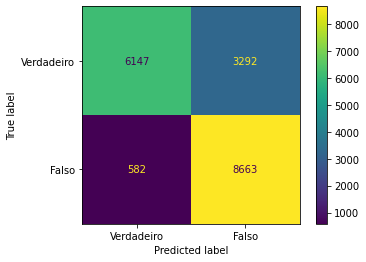

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, values_format='d', display_labels=['Verdadeiro', 'Falso'])
plt.show()

O gráfico abaixo mostra o impacto da força de regularização no f1. Observe que o f1 decresce ligeiramente para C maior que 0.02. Isso significa que grandes forças de regualrização não irão necessariamente resultar no melhor modelo.

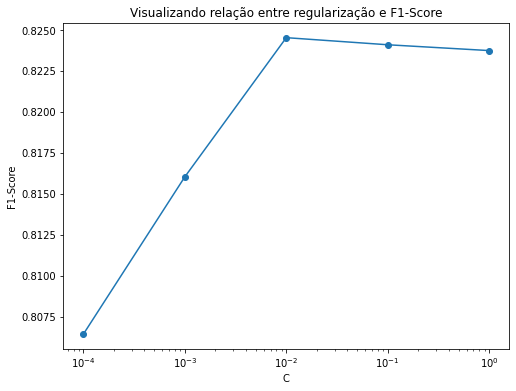

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(logreg_C, avg_scores, '-o')
plt.title('Visualizando relação entre regularização e F1-Score')
plt.xlabel('C')
plt.ylabel('F1-Score')
plt.xscale('log')
plt.show()

### Árvore de Decisão

Árvores de decisão podem ser utilizadas tanto para regressão quanto classificação. Como o nome sugere, se baseia em árvores de decisão para prever valores ou classes, onde os galhos representam informações sobre uma entrada e as folhas representam conclusões.

Aqui iremos aplicar otimização bayesiana para encontrar os melhores hiperparâmetros do modelo. A classe ```BayesSearchCV``` da biblioteca **scikit-optimize** permite que a validação cruzada seja aplicada juntamente ao processo de busca dos hiperparâmetros.

In [ ]:
!pip install scikit-optimize

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

model = DecisionTreeClassifier()
params = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(1, 20),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5),
    'max_leaf_nodes': Integer(10, 30)
}

opt = BayesSearchCV(model, params, scoring='f1', cv=folds, verbose=0, random_state=31, n_jobs=10)
opt.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

BayesSearchCV(cv=10, error_score='raise',
              estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features=None,
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               presort='deprecated',
                                               random_state=None,
                                               splitter='best'),
              f...
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'),

Diferentemente da classe ```GridSearchCV``` da biblioteca **scikit-learn**, a classe ```BayesSearchCV``` não suporta múltiplas métricas ao mesmo tempo, sendo possível apenas executar um otimizador com uma métrica diferente por vez, fazendo com que o processo consuma muito tempo. Neste artigo, iremos apenas avaliar a estatística **f1** obtida na validação cruzada.

In [ ]:
print(f'Melhor f1 obtido: {opt.best_score_}')
mean_f1 = np.mean(opt.cv_results_['mean_test_score'])
print(f'F1 médio obtido: {mean_f1}')

Com a propriedade ```best_params_``` do otimizador, é possível verificar o resultado da busca dos hiperparâmetros. Estes foram os valores obtidos:

In [ ]:
opt.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 4),
             ('max_leaf_nodes', 11),
             ('min_samples_leaf', 3),
             ('min_samples_split', 5)])

Agora, comparemos o desempenho do modelo sem aplicar validação cruzada no conjunto de dados.

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=11, min_samples_leaf=3, min_samples_split=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

Acurácia: 0.7853778634125455
Precisão: 0.7059240028321926
Recall: 0.970578691184424
F1: 0.8173619967207142


Agora, observemos a matriz de confusão do modelo.

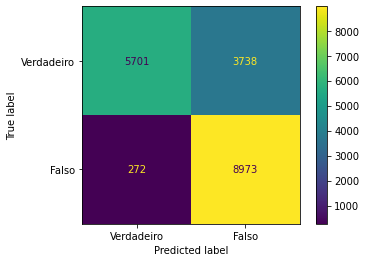

In [ ]:
plot_confusion_matrix(opt, X_test, y_test, values_format='d', display_labels=['Verdadeiro', 'Falso'])
plt.show()

### LightGBM

LightGBM também é um modelo baseado em árvores, mas diferentemente de uma árvore de decisão, são utilizadas várias delas, o que caracteriza um **ensemble**. Nesta técnica, são utilizados preditores fracos (modelos gerados aleatoriamente, que, em geral, possuem métricas abaixo do esperado) se juntam para formar um preditor forte final. Em modelos como este, é aplicado a técnica de **boosting** onde cada modelo é treinado de forma sequencial e adaptativa, ou seja, um modelo base irá depender dos anteriores, e, no final, serão combinados.

No LightGBM ainda é aplicada mais uma técnica denominada **gradient boosting** na qual é criada uma corrente de modelos fracos, onde cada modelo tem a função de minimizar o erro do anterior atráves de uma função de perda. Cada modelo tem seus parâmetros reajustados de acordo com uma taxa de aprendizagem, em um processo bastante similar ao gradiente descendente.

Novamente iremos utilizar otimização bayesiana para encontrar os melhores hiperparâmetros do modelo que se adequarem aos dados.

In [ ]:
from lightgbm import LGBMClassifier
from skopt.space import Real

In [ ]:
model = LGBMClassifier()
params = {
    'learning_rate': [1e-3, 1e-2, 1e-1],
    'num_leaves': Integer(2, 50),
    'min_child_samples': Integer(2, 10),
    'subsample': [0.05, 1],
    'colsample_bytree': Real(0.1, 1)
}

opt = BayesSearchCV(model, params, scoring='f1', cv=folds, verbose=0, random_state=31, n_jobs=10)
opt.fit(X_train, y_train)

BayesSearchCV(cv=10, error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=100,
                                       n_jobs=-1, num_leaves=31, objective=None,
                                       random_state=None, reg_alpha=0.0,
                                       reg_lambda=0.0, sile...
              refit=True, return_train_score=False, scoring='f1',
              search_spaces={'colsample_bytree': Real(low=0.1, high=1, prior='uniform', transform='identity'),
                             'learning_rate': [0.001, 0.01, 0.1],
                    

Como na árvore de decisão, iremos avaliar o f1 obtido na validação cruzada.

In [ ]:
print(f'Melhor f1 obtido: {opt.best_score_}')
mean_f1 = np.mean(opt.cv_results_['mean_test_score'])
print(f'F1 médio obtido: {mean_f1}')

Melhor f1 obtido: 0.8248919727680017
F1 médio obtido: 0.8217138617617116


Estes foram os melhores hiperparâmetros obtidos pelo otimizador:

In [ ]:
opt.best_params_

OrderedDict([('colsample_bytree', 0.5904839476756047),
             ('learning_rate', 0.1),
             ('min_child_samples', 8),
             ('num_leaves', 20),
             ('subsample', 0.8420571542413413)])

Agora vamos testar o modelo com os hiperparâmetros obtidos sem validação cruzada.

In [ ]:
model = LGBMClassifier(colsample_bytree=0.5904839476756047, learning_rate=0.1, min_child_samples=8, num_leaves=20, subsample=0.8420571542413413)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

Acurácia: 0.7946906444016271
Precisão: 0.728247109460714
Recall: 0.9333693888588426
F1: 0.8181473404759647


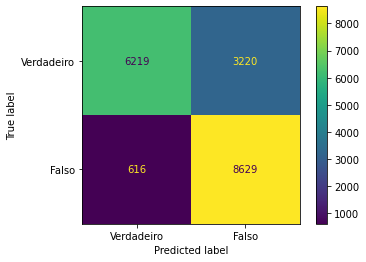

In [ ]:
plot_confusion_matrix(model, X_test, y_test, values_format='d', display_labels=['Verdadeiro', 'Falso'])
plt.show()

## Considerações finais

Os modelos apresentados neste artigo obtiveram peformances bastante similares. A tabela abaixo resume as métricas obtidas.

Modelo | Acurácia | Precisão | Recall | F1 
---|---|---|---|---
Regressão logística|0.7981964453891113|0.7307953653490413|0.9458962151034228|0.824541995233784
Árvore de Decisão|0.7853778634125455|0.7059240028321926|0.970578691184424|0.8173619967207142
LightGBM|0.7946906444016271|0.728247109460714|0.9333693888588426|0.8181473404759647


De modo geral, os três modelos são muito bons em tratar falsos negativos, visto o alto valor de recall presente, apesar do modelo LightGBM apresentar um valor um pouco menor que o da árvore de decisão. Isso significa que os modelos identificam muito bem os clientes que não desejam obter um seguro para seu veículo. 

Por outro lado, os modelos terão um pouco mais de trabalho em identificar clientes que realmente querem obter um seguro veículo, visto que a precisão se mantém em torno de 0.7, tornando relativamente frequente a ocorrência de falsos positivos. Isso pode ocasionar em ligações de clientes irritados descobrindo que estão pagando pelo seguro veículo sem serem contatados.

Por fim, é seguro afirmar que não é recomendável confiar cegamente nos modelos acima, pois os níveis de precisão podem acarretar em falsos positivos que podem prejudicar a seguradora, mas podem se tornar ferramentas de apoio à decisão bastante úteis caso os modelos sejam utilizados em produção.'